# Bitcoin link prediction

Material for Lecture 4 of the Risk Analytics workshop at the University of Ljubljana.

Please note: this implementation has not been optimized and is in need of refactoring.

In [1]:
import os
import sys

import json
from pprint import pprint

import requests
import requests_cache

from itertools import combinations_with_replacement as cwr

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import networkx as nx

from gensim.models import Word2Vec

from sklearn.metrics import roc_auc_score as auc

#from node2vec import node2vec as n2v
from node2vec import node2vec as n2v

from importlib import reload

reload(n2v)

pd.options.mode.chained_assignment = None
plt.style.use('ggplot')
%matplotlib inline

In [2]:
def learn_embeddings(walks, dimensions, window_size, workers, n_iter=1):
    '''
    Learn embeddings by optimizing the Skipgram objective using SGD.
    '''
    
    # Python 2 or 3
    if sys.version_info.major < 3:
        walks = [map(str, walk) for walk in walks]
    else: # Python 3
        walks = [list(map(str,walk)) for walk in walks]
        
    model = Word2Vec(walks, size=dimensions, window=window_size, min_count=0, sg=1, workers=workers, iter=n_iter)
    #model.save_word2vec_format(args.output)
    return model


def common_neighbor(pair, G):
    com_nbr = len(list(nx.common_neighbors(G, pair[0], pair[1])))

    return com_nbr


def hadamard(pair, model):
    hadamard = np.dot(model.wv[pair[0]], model.wv[pair[1]])
    
    return hadamard

# Create the bitcoin transaction graph and extract key metrics

In [ ]:
graph_df = pd.read_csv("../data/btc_df.csv")
# Filter out the mining transactions
graph_df = graph_df.loc[~(graph_df.addr_from == 'mining'), :]
graph_df = graph_df.rename(columns={'value': 'weight'})

run_list = []
for height_max in range(55000, 65000, 1000):
    run_dict = {}
    print(height)
    height_train = int(height_max*0.90)

    run_dict['height_max'] = height_max
    run_dict['height_train'] = height_train
    graph_df = graph_df.loc[graph_df.height < height_max, :]
    graph_train = graph_df.loc[graph_df.height < height_train, :]
    graph_test = graph_df.loc[graph_df.height >= height_train, :]
    graph_df.head()

    # Create edge train and test sets
    edge_df = graph_df[['addr_from', 'addr_to']]#, 'weight']]
    edge_df['data'] = graph_df[['weight', 'height']].to_dict(orient='records')
    #edge_df['data'] = graph_df[['weight']].to_dict(orient='records')
    edge_list = edge_df.values.tolist()

    edge_train = graph_train[['addr_from', 'addr_to']]#, 'weight']]
    edge_train['data'] = graph_train[['weight', 'height']].to_dict(orient='records')
    #edge_df['data'] = graph_df[['weight']].to_dict(orient='records')
    edge_train_list = edge_train.values.tolist()

    edge_test = graph_test[['addr_from', 'addr_to']]#, 'weight']]
    edge_test['data'] = graph_test[['weight', 'height']].to_dict(orient='records')
    #edge_df['data'] = graph_df[['weight']].to_dict(orient='records')
    edge_test_list = edge_test.values.tolist()


    # Create graphs, full, train and test
    G = nx.MultiDiGraph(edge_list)
    G_train = nx.MultiDiGraph(edge_train_list)
    G_test = nx.MultiDiGraph(edge_test_list)
    #nx.draw_networkx(G, with_labels=False, node_size = 80)

    print("Number of nodes: {0}\nNumber of edges: {1}".format(G.number_of_nodes(), G.number_of_edges()))
    print("Number of train nodes: {0}\nNumber of edges: {1}".format(G_train.number_of_nodes(), G_train.number_of_edges()))
    print("Number of test nodes: {0}\nNumber of edges: {1}".format(G_test.number_of_nodes(), G_test.number_of_edges()))

    # Keep only nodes with valency at least 3
    nodes_ge3 = [n for n in G.nodes() if G.in_degree(n) + G.out_degree(n) >=3]
    G = G.subgraph(nodes_ge3)
    #degs_in = G.in_degree()
    #print(degs_in, '\n')
    #degs_out = G.out_degree()

    nodes_train_ge3 = [n for n in G_train.nodes() if G_train.in_degree(n) + G_train.out_degree(n) >=3]
    G_train = G_train.subgraph(nodes_train_ge3)
    #degs_train_in = G_train.in_degree()
    #print(degs_in, '\n')
    #degs_train_out = G_train.out_degree()

    nodes_test_ge3 = [n for n in G_test.nodes() if G_test.in_degree(n) + G_test.out_degree(n) >=3]
    G_test = G_test.subgraph(nodes_test_ge3)


    G_und = G.to_undirected()
    G_train_und = G_train.to_undirected()
    G_test_und = G_test.to_undirected()
    # Assign transaction amount as weight
    print("Number of nodes: {0}\nNumber of edges: {1}".format(G.number_of_nodes(), G.number_of_edges()))
    print("Number of nodes: {0}\nNumber of edges: {1}".format(G_train.number_of_nodes(), G_train.number_of_edges()))
    print("Number of nodes: {0}\nNumber of edges: {1}".format(G_test.number_of_nodes(), G_test.number_of_edges()))

    run_dict['n_train_nodes'] = G_train.number_of_nodes()
    run_dict['n_train_edges'] = G_train.number_of_edges()
    run_dict['n_test_nodes'] = G_test.number_of_nodes()
    run_dict['n_test_edges'] = G_test.number_of_edges()

    # node2vec parameters
    p, q = 1,3

    G_n2v = n2v.Graph(G_train, True, p, q)
    G_n2v.preprocess_transition_probs()


    walks = G_n2v.simulate_walks(20, 10)

    # word2vec params
    dimensions = 100
    window_size = 5
    workers =4
    n_iter = 10
    model = learn_embeddings(walks, dimensions, window_size, workers, n_iter=n_iter)

    # Define train and test node pairs and edges
    pairs_train = cwr(G_train.nodes(), 2)
    pairs_train_list = list(pairs_train)

    pairs_test = cwr(G_test.nodes(), 2)
    pairs_test_list = list(set(pairs_test).intersection(set(pairs_train_list)))

    e_train = G_train.edges()
    e_test = G_test.edges()

    # Create dataframe for training and testing
    %time edge_mask = [pair in e_train or (pair[1], pair[0]) in e_train for pair in pairs_train_list]
    train_df = pd.DataFrame({'node_pair': pairs_train_list})
    train_df['edge_mask'] = edge_mask
    %time train_df['com_nbr'] = [common_neighbor(pair, G_train_und) for pair in pairs_train_list]
    %time train_df['hadamard'] = [np.dot(model.wv[pair[0]], model.wv[pair[1]]) for pair in pairs_train_list]

    print(train_df.shape)
    print(sum(train_df['edge_mask']))
    print(auc(train_df['edge_mask'], train_df['com_nbr']))
    print(auc(train_df['edge_mask'], train_df['hadamard']))
    run_dict['auc_common_neighbors_train'] = auc(train_df['edge_mask'], train_df['com_nbr'])
    run_dict['auc_n2v_train'] = auc(train_df['edge_mask'], train_df['hadamard'])
    
    %time edge_mask = [pair in e_test or (pair[1], pair[0]) in e_test for pair in pairs_test_list]
    test_df = pd.DataFrame({'node_pair': pairs_test_list})
    test_df['edge_mask'] = edge_mask
    %time test_df['com_nbr'] = [common_neighbor(pair, G_test_und) for pair in pairs_test_list]
    %time test_df['hadamard'] = [np.dot(model.wv[pair[0]], model.wv[pair[1]]) for pair in pairs_test_list]

    print(auc(test_df['edge_mask'], test_df['com_nbr']))
    print(auc(test_df['edge_mask'], test_df['hadamard']))
    run_dict['auc_common_neighbors_test'] = auc(test_df['edge_mask'], test_df['com_nbr'])
    run_dict['auc_n2v_test'] = auc(test_df['edge_mask'], test_df['hadamard'])
    
    run_list.append(run_dict)

Number of nodes: 16395
Number of edges: 22869
Number of train nodes: 8971
Number of edges: 10928
Number of test nodes: 7495
Number of edges: 11941
Number of nodes: 3673
Number of edges: 7681
Number of nodes: 242
Number of edges: 417
Number of nodes: 3442
Number of edges: 7194
Walk iteration:
1 / 20
2 / 20
3 / 20
4 / 20
5 / 20
6 / 20
7 / 20
8 / 20
9 / 20
10 / 20
11 / 20
12 / 20
13 / 20
14 / 20
15 / 20
16 / 20
17 / 20
18 / 20
19 / 20
20 / 20
CPU times: user 923 ms, sys: 7.17 ms, total: 930 ms
Wall time: 975 ms
CPU times: user 192 ms, sys: 2.86 ms, total: 194 ms
Wall time: 202 ms
CPU times: user 114 ms, sys: 888 µs, total: 115 ms
Wall time: 121 ms
(29403, 4)
246
0.691062347911
0.789255449402
CPU times: user 95.9 ms, sys: 1.62 ms, total: 97.6 ms
Wall time: 110 ms
CPU times: user 1.04 ms, sys: 4 µs, total: 1.04 ms
Wall time: 1.04 ms
CPU times: user 885 µs, sys: 302 µs, total: 1.19 ms
Wall time: 962 µs
0.665441176471
0.90931372549
Number of nodes: 16395
Number of edges: 22869
Number of train

In [11]:
run_df = pd.DataFrame(run_list)

In [12]:
#run = pd.Series(run_dict)
run_df.set_index('height_max', inplace=True)
run_df.to_csv('../results/n2v_runs.csv', header=False)
run_df

,auc_common_neighbors_test,auc_common_neighbors_train,auc_n2v_test,auc_n2v_train,height_train,n_test_edges,n_test_nodes,n_train_edges,n_train_nodes
height_max,,,,,,,,,
55000,0.665441,0.691062,0.909314,0.789255,49500,7194,3442,417,242
56000,0.660656,0.679586,0.877049,0.786928,50400,6990,3384,626,310
57000,0.584107,0.697628,0.812541,0.800601,51300,6817,3299,812,398
58000,0.716900,0.770120,0.840149,0.557500,52200,484,203,7157,3494


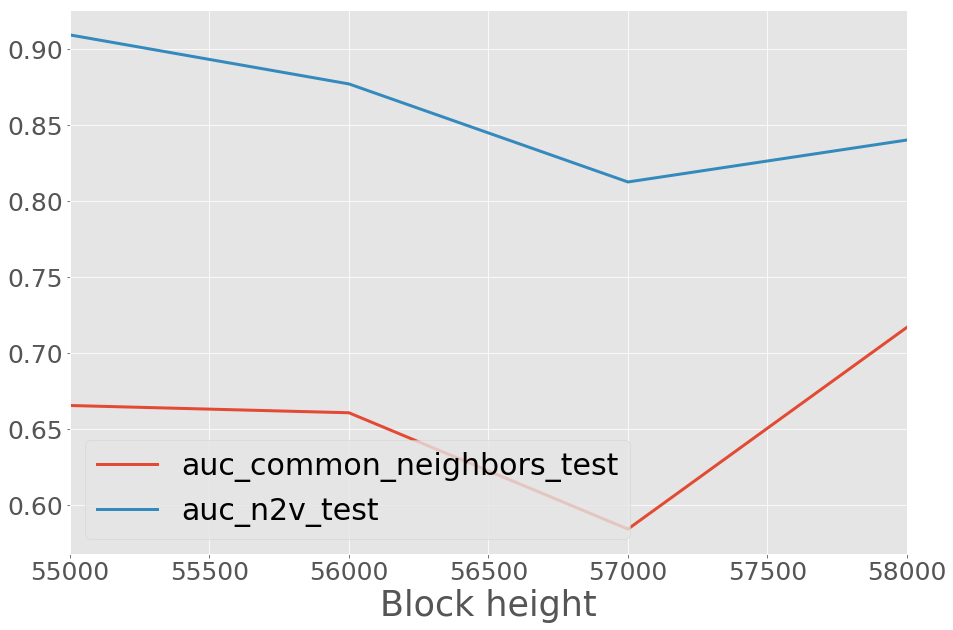

In [14]:
fig_dir = "../slides/figures"
plt.figure();
ax = run_df[['auc_common_neighbors_test', 'auc_n2v_test']].plot(figsize=(15, 10), linewidth=3.0);
ax.set_xlabel("Block height", fontsize=35)
plt.legend(loc=3, prop={'size': 30})
plt.tick_params(axis='both', which='major', labelsize=25)
plt.savefig(os.path.join(fig_dir, "cn_vs_n2v.png"), format='png')